In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [33]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [34]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

sample_dir = f'{base_dir}/projects/hierarchical_quicknat/outs/hierarchical_quicknat_KORA_v2/hierarchical_quicknat_KORA_v2_predictions_KORA/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/hierarchical_quicknat/outs/hierarchical_quicknat_KORA_v2/hierarchical_quicknat_KORA_v2_predictions_KORA/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [4]:
# sample_count_dict = {}
# for r_id, sample in enumerate(sample_paths):
#     print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

#     split_str = sample.split('/')[-1].split('.')[0]
#     v_id = split_str.split('_')[0]
#     sample_id = split_str.split('_')[-1]
#     s_data = nb.load(sample).get_fdata()
#     unique_vals, counts = np.unique(s_data, return_counts=True)
#     if v_id not in sample_count_dict.keys():
#         sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
#         sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
#     if sample_id == 'seg':
#         sample_count_dict[v_id]['seg_spleen'] = counts[2]
#         sample_count_dict[v_id]['seg_liver'] = counts[1]
#     else:
#         sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
#         sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

# print(sample_count_dict)
# df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
# df.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 12649, '1_spleen': 12657, '2_spleen': 12652, '3_spleen': 12662, '4_spleen': 12647, '5_spleen': 12680, '6_spleen': 12651, '7_spleen': 12661, '8_spleen': 12641, '9_spleen': 12650, '0_liver': 107825, '1_liver': 107890, '2_liver': 107925, '3_liver': 107865, '4_liver': 107909, '5_liver': 107827, '6_liver': 107890, '7_liver': 107880, '8_liver': 107896, '9_liver': 107836, 'seg_spleen': 107880, 'seg_liver': 12656}, 'KORA2459526': {'0_spleen': 20359, '1_spleen': 20345, '2_spleen': 20365, '3_spleen': 20346, '4_spleen': 20362, '5_spleen': 20373, '6_spleen': 20378, '7_spleen': 20364, '8_spleen': 20356, '9_spleen': 20379, '0_liver': 169591, '1_liver': 169568, '2_liver': 169594, '3_liver': 169564, '4_liver': 169553, '5_liver': 169594, '6_liver': 169563, '7_liver': 169565, '8_liver': 169637, '9_liver': 169544, 'seg_spleen': 169569, 'seg_liver': 20362}, 'KORA2455268': {'0_spleen': 6891, '1_spleen': 6889, '2_spleen': 6891, '3_spleen': 6896, '4_spleen': 

In [35]:
df = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_sample_count_report.csv')

In [36]:
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [37]:
df_reports = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_report.csv')

In [38]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv')

In [39]:
df = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv')

In [40]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']



In [ ]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

In [25]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)

try:
    X = pd.get_dummies(df.loc[y.index, feats], drop_first=True)
#         X = X.fillna(0)
    mod = sm.OLS(y_classes, X)
    fii = mod.fit()
    print(fii.summary())
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
#     p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
except Exception as e:
    print(e)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     8.862
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           1.64e-16
Time:                        16:49:43   Log-Likelihood:                -96.062
No. Observations:                 153   AIC:                             236.1
Df Residuals:                     131   BIC:                             302.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                   

In [ ]:

p_value_df.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_p_values.csv', index_label='feats')
        

In [41]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [29]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,coeff,p_value
age,2400.861815,8.499854e-79
height,806.703552,1.654727e-103
sex,150418.945055,3.800569e-38
weight,1653.224821,1.020902e-127
smoker_former,140776.161765,1.101893e-20
smoker_irregular,132843.111111,4.663286e-03
smoker_non-smoker,134755.576923,1.010317e-13
smoker_regular,139926.083333,5.646162e-07
smoking-packages,4148.496886,2.270101e-15
bmi-who_normal,114958.333333,4.225527e-08


In [28]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, medication_feats, alcohol_feats, hbalc_feats, triglyceride, hypertension,  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
feats = flatten(all_feats)
df_c = df_c.fillna(0)
# df = df.dropna()
p_values = {}
y = df["seg_spleen"].copy()
# y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
y_classes = y.values
# print(y_classes, pd.get_dummies(y).values)

try:
    X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
#         X = X.fillna(0)
    mod = sm.OLS(y_classes, X)
    fii = mod.fit()
    print(fii.summary())
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
#     p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
except Exception as e:
    print(e)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     48.22
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           2.87e-32
Time:                        16:56:04   Log-Likelihood:                -1725.4
No. Observations:                 153   AIC:                             3465.
Df Residuals:                     146   BIC:                             3486.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                -787.0306    200.01

In [21]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,coeff,p_value
age,287.380570,1.530796e-57
height,96.933943,1.143606e-68
sex,18337.197802,3.637452e-34
weight,199.515704,5.172259e-77
smoker_former,17773.514706,8.551827e-21
smoker_irregular,17285.333333,3.446138e-03
smoker_non-smoker,16126.365385,2.620340e-12
smoker_regular,13829.625000,1.128459e-04
smoking-packages,503.287514,3.823825e-14
bmi-who_normal,12248.571429,4.930717e-06


In [20]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
feats = flatten(all_feats)
df_c = df_c.fillna(0)
p_values = {}
y = df["seg_liver"].copy()
# y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
y_classes = y.values
# print(y_classes, pd.get_dummies(y).values)

try:
    X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
#         X = X.fillna(0)
    mod = sm.OLS(y_classes, X)
    fii = mod.fit()
    print(fii.summary())
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
#     p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
except Exception as e:
    print(e)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     3.357
Date:                Fri, 25 Oct 2019   Prob (F-statistic):           7.41e-07
Time:                        16:40:33   Log-Likelihood:                -1516.0
No. Observations:                 153   AIC:                             3100.
Df Residuals:                     119   BIC:                             3203.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age             

In [44]:
df_c.rename(columns={'bmi-numeric':'bmi_numeric'}, 
                 inplace=True)

In [46]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]

mod_s = []
all_feats_simple0 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['age']]
all_feats_simple00 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['age', 'sex']]
all_feats_simple000 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'], ['age', 'sex', 'bmi_numeric']]
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

for feats_list in [all_feats_simple000]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
        print(target)
        for i in range(2):
            
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
#                 X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'age', 'sex', 'bmi_numeric']
------------------------------------------------------------
             df        sum_sq       mean_sq         F        PR(>F)
X           6.0  1.806081e+09  3.010134e+08  8.533116  5.857776e-08
Residual  147.0  5.185559e+09  3.527591e+07       NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     10.23
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           1.99e-08
Time:                        13:34:14   Log-Likelihood:                -1543.5
No. Observations:                 153   AIC:                             3099.
Df Residuals:                     147   BIC:                             3117.


In [47]:
['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight'], 
['bmi-numeric']

mod_liver = ols('diabetes_status ~ age + sex + bmi_numeric + seg_liver+seg_spleen'
           , df_c).fit()
mod_spleen = ols('diabetes_status ~ age + sex + bmi_numeric + seg_spleen'
           , df_c).fit()

# mod_liver = ols('seg_liver ~ age + sex + diabetes_status_0 + diabetes_status_1 + diabetes_status_2 + height + weight'
#            , df_c).fit()
# mod_spleen = ols('seg_spleen ~ age + sex + diabetes_status_0 + diabetes_status_1 + diabetes_status_2 + height + weight'
#            , df_c).fit()

In [48]:

full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                df     sum_sq    mean_sq          F        PR(>F)
age            1.0   6.417938   6.417938  18.971384  2.475468e-05
sex            1.0   4.683501   4.683501  13.844401  2.820294e-04
bmi_numeric    1.0  10.878418  10.878418  32.156536  7.299728e-08
seg_liver      1.0   0.116633   0.116633   0.344765  5.579921e-01
seg_spleen     1.0   4.291689   4.291689  12.686206  4.968777e-04
Residual     147.0  49.729468   0.338296        NaN           NaN


In [49]:

full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                df     sum_sq    mean_sq          F        PR(>F)
age            1.0   6.417938   6.417938  18.909252  2.538039e-05
sex            1.0   4.683501   4.683501  13.799060  2.876746e-04
bmi_numeric    1.0  10.878418  10.878418  32.051223  7.558363e-08
seg_spleen     1.0   3.905514   3.905514  11.506867  8.895954e-04
Residual     148.0  50.232276   0.339407        NaN           NaN


In [50]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

In [ ]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

In [ ]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

In [ ]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

In [51]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])


/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [ ]:
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'pre_diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs pre_diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('pre_diabetic_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'pre_diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs pre_diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('pre_diabetic_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'pre_diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs pre_diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('pre_diabetic_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'pre_diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs pre_diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('pre_diabetic_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)

print('normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_avg_spleen'].dropna().values)
print('normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)
print('diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')


In [ ]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values



t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)

print('normal_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)
print('normal_dice_mean vs diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)
print('diabetic_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')


In [ ]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)

print('normal_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)
print('diabetic_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'diabetic_ged'].dropna().values)
print('normal_ged vs diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'pre_diabetic_sncc'].dropna().values)
print('normal_sncc vs pre_diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('normal_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('pre_diabetic_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -3.48232272284658
p: 0.0006746073067002347


normal_seg_spleen vs diabetic_seg_spleen
t: -4.882538380676389
p: 3.348126093061215e-06


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 1.6872168841875226
p: 0.09766960436389012


normal_seg_liver vs pre_diabetic_seg_liver
t: -1.396650554294875
p: 0.1648625640501467


normal_seg_liver vs diabetic_seg_liver
t: -1.1831585605461927
p: 0.2391448536459703


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.10754103198172134
p: 0.9147817306969075




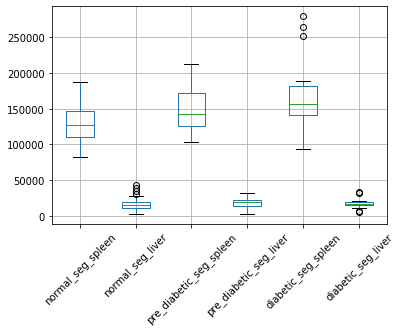

In [52]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')